# 1.Library

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import tensorflow
from kerastuner.tuners import RandomSearch
from scipy import stats
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from skopt import BayesSearchCV


C:\Users\giakh\AppData\Local\Temp\ipykernel_20864\1732507516.py:12: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


# 2.Read data from csv file

In [2]:
def clean(features, data):
    choose = np.array([True] * len(data))
    for feature in features:
        z_score = stats.zscore(data[feature])
        z_score = np.abs(z_score) < 3
        choose = choose & z_score
    data_clean = data[choose]
    return data_clean

In [3]:
df = pd.read_csv('data.csv')
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 657681 entries, 0 to 657680
Data columns (total 24 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   row       657681 non-null  int64  
 1   col       657681 non-null  int64  
 2   datetime  657681 non-null  object 
 3   AWS       657681 non-null  float64
 4   CAPE      657681 non-null  float64
 5   CIN       657681 non-null  float64
 6   EWSS      657681 non-null  float64
 7   IE        657681 non-null  float64
 8   ISOR      657681 non-null  float64
 9   KX        657681 non-null  float64
 10  PEV       657681 non-null  float64
 11  R250      657681 non-null  float64
 12  R500      657681 non-null  float64
 13  R850      657681 non-null  float64
 14  SLHF      657681 non-null  int64  
 15  SLOR      657681 non-null  float64
 16  SSHF      657681 non-null  int64  
 17  TCLW      657681 non-null  float64
 18  TCW       657681 non-null  float64
 19  TCWV      657681 non-null  float64
 20  U250

In [4]:
print(df.describe())

                 row            col            AWS           CAPE  \
count  657681.000000  657681.000000  657681.000000  657681.000000   
mean       26.968751     113.629924       0.363923     734.002861   
std        25.093664      16.729481       2.258714    1120.479222   
min         0.000000      55.000000       0.000000       0.000000   
25%         6.000000     104.000000       0.000000       2.750000   
50%        17.000000     114.000000       0.000000     130.500000   
75%        44.000000     122.000000       0.000000    1072.250000   
max        87.000000     167.000000     121.600000    8722.750000   

                 CIN           EWSS             IE           ISOR  \
count  657681.000000  657681.000000  657681.000000  657681.000000   
mean     5314.441979    -212.316457      -0.000039       0.450298   
std      4872.563964     670.633511       0.000048       0.181226   
min         0.000003  -14114.900000      -0.000315       0.000000   
25%       187.875000    -395.1600

In [5]:
import matplotlib.pyplot as plt

features_csv = [
    'AWS', 'CAPE',	'CIN',	'EWSS',	'IE',	'ISOR',	'KX',	'PEV',	'R250',	'R500',	'R850',	'SLHF',	'SLOR',	'SSHF',	'TCLW',	'TCW',	'TCWV',	'U250',	'U850',	'V250',	'V850'
]


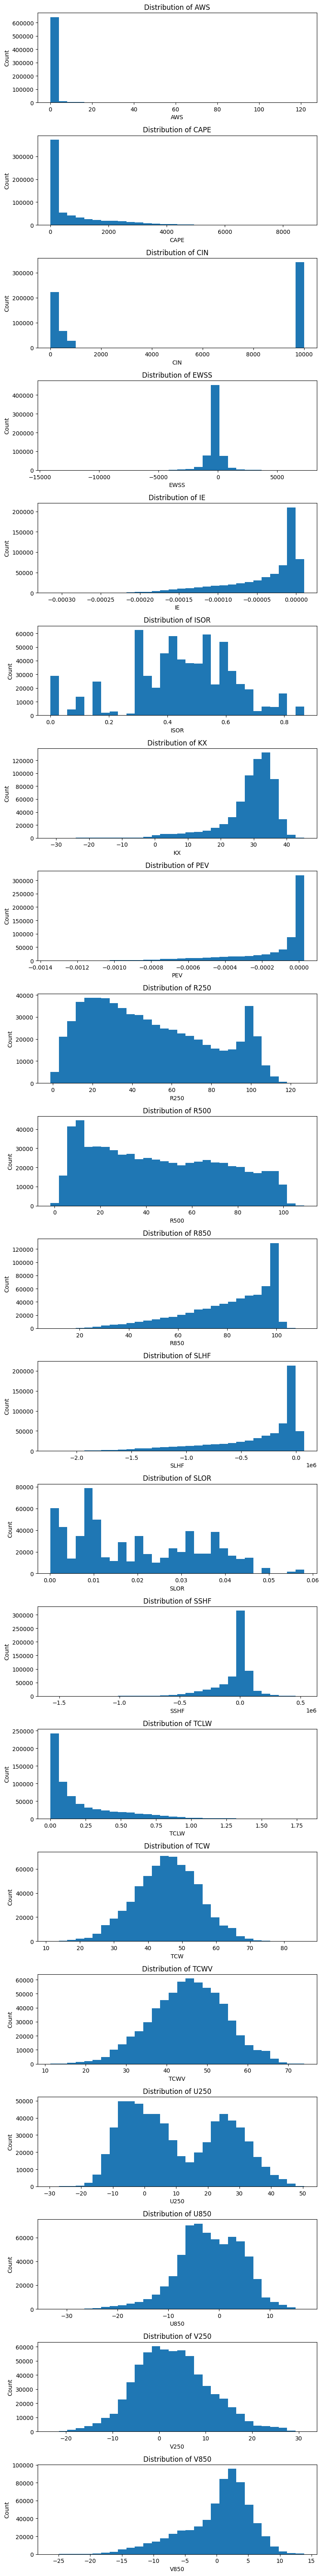

In [6]:
ingress_columns = features_csv
import matplotlib.pyplot as plt
fig, axes = plt.subplots(len(ingress_columns), 1, figsize=(8, 3 * len(ingress_columns)))
for i, col in enumerate(ingress_columns):
    axes[i].hist(df[col].dropna(), bins=30)
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
fig.tight_layout()
plt.show()

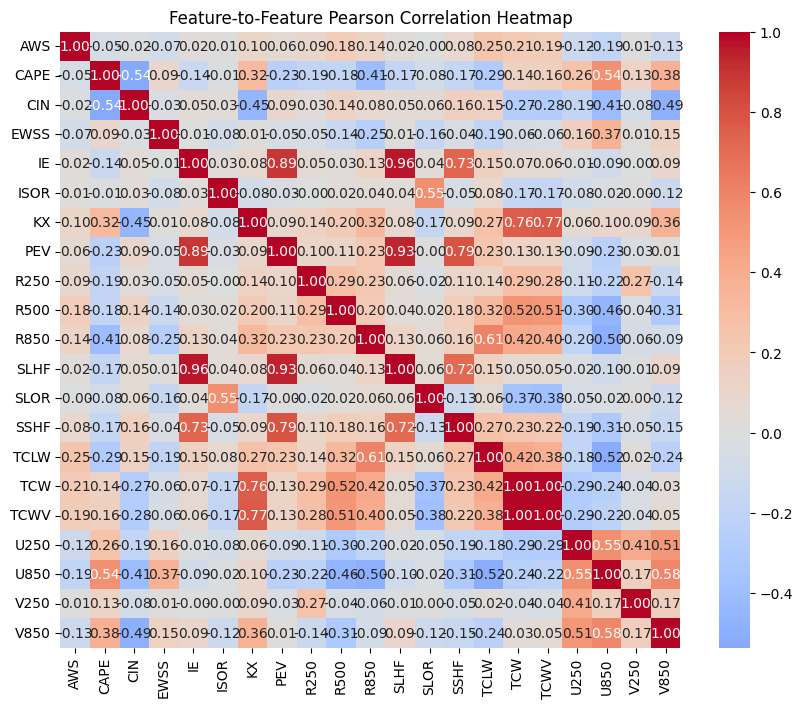

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df[features_csv].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Feature-to-Feature Pearson Correlation Heatmap')
plt.show()

In [8]:

df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(by=['row', 'col'], ascending=[True, True]).reset_index(drop=True)
features = [
    'AWS2', 'CAPE', 'V850', 'EWSS', 'KX', 'U250', 'U850', 'CIN', 'V250', 'R250',
    'hour_sin','hour_cos','doy_sin','doy_cos'
]
target = 'AWS'
df['AWS2'] = df['AWS']

df = clean(features[0:10],df)

df['year'] = df['datetime'].dt.year
df['hour']     = df['datetime'].dt.hour
df['doy']      = df['datetime'].dt.dayofyear
df['hour_sin'] = np.sin(2*np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2*np.pi * df['hour'] / 24)
df['doy_sin']  = np.sin(2*np.pi * df['doy']  / 365)
df['doy_cos']  = np.cos(2*np.pi * df['doy']  / 365)


dftrain = df[df['datetime'] <= pd.Timestamp('2020-10-15 23:00:00')].reset_index(drop=True)
dftest = df[df['datetime'] >= pd.Timestamp('2020-10-16 00:00:00')].reset_index(drop=True)
print(len(df))
scaler_f = StandardScaler()
dftrain[features] = scaler_f.fit_transform(dftrain[features])
dftest[features] = scaler_f.transform(dftest[features])


dftest.head()

600608


,row,col,datetime,AWS,CAPE,CIN,EWSS,IE,ISOR,KX,...,V250,V850,AWS2,year,hour,doy,hour_sin,hour_cos,doy_sin,doy_cos
0,0,104,2020-10-16 00:00:00,1.4,-0.778566,1.151669,-0.157100,-0.000008,0.676296,0.691164,...,0.308077,-0.461880,2.247177,2020,0,290,-0.005889,1.428931,-1.120592,1.234326
1,0,104,2020-10-16 01:00:00,1.4,-0.773494,1.151669,-0.184226,-0.000014,0.676296,0.533721,...,0.211001,-0.586356,2.247177,2020,1,290,0.362716,1.381061,-1.120592,1.234326
2,0,104,2020-10-16 02:00:00,0.0,-0.764092,1.151669,-0.253074,-0.000025,0.676296,0.406218,...,0.199645,-0.850797,-0.189937,2020,2,290,0.706200,1.240713,-1.120592,1.234326
3,0,104,2020-10-16 03:00:00,0.0,-0.752339,1.151669,-0.340492,-0.000034,0.676296,0.339875,...,0.288680,-1.145032,-0.189937,2020,3,290,1.001157,1.017450,-1.120592,1.234326
4,0,104,2020-10-16 04:00:00,0.0,-0.755308,1.151669,-0.280227,-0.000047,0.676296,0.275151,...,0.363835,-1.287848,-0.189937,2020,4,290,1.227486,0.726489,-1.120592,1.234326


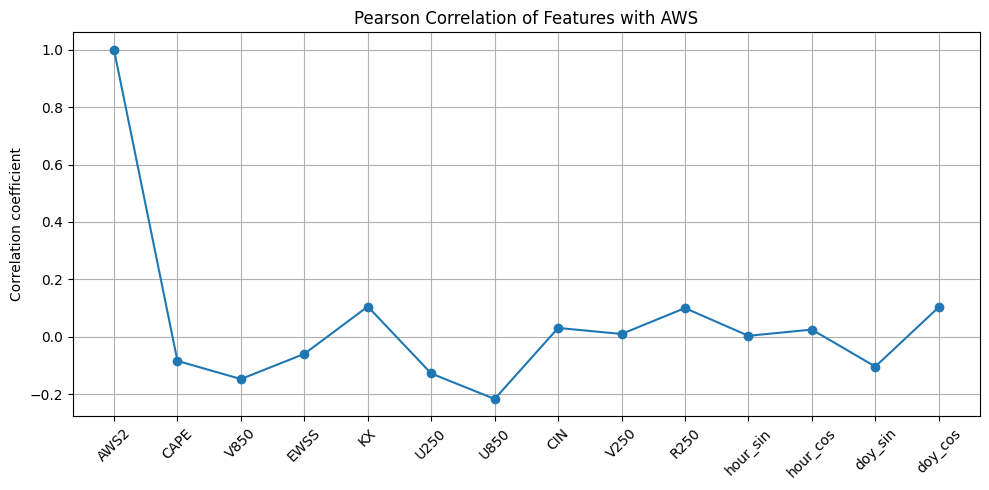

In [9]:
corr_with_target = df[features + ['AWS']].corr()['AWS'].drop('AWS')
plt.figure(figsize=(10, 5))
plt.plot(corr_with_target.index, corr_with_target.values, marker='o', linestyle='-')
plt.title('Pearson Correlation of Features with AWS')
plt.ylabel('Correlation coefficient')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
def make_sequences(data, feats, tgt, window_size, horizon):
    X, y = [], []
    arr_f = data[feats].values
    arr_t = data[tgt].values
    time = data['datetime'].tolist()
    for i in range(window_size, len(data)-horizon+1):
        check = False
        for j in range(i-window_size+1, i+horizon):
            if (time[j] - time[j-1]).total_seconds() != 3600:
                check = True
                break
        if check:
            continue
        X.append(arr_f[i-window_size:i])
        y.append(arr_t[i:i+horizon])
    return np.array(X), np.array(y)


In [11]:
window_size = 1
horizon     = 6

X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (351315, 1, 14) (351315, 6)
Test shapes: (74038, 1, 14) (74038, 6)


In [12]:
def model_eval(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    mae = mean_absolute_error(y_test,y_pred)
    print("Mean Absolute Error:", mae)
    r2 = r2_score(y_test,y_pred)
    print("R-squared:", r2)
    corr, p = stats.pearsonr(y_test.reshape(-1), y_pred.reshape(-1))
    print("Pearson Correlation Coefficient:", corr)

# 3.Models

## 3.1 Lasso

In [13]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [14]:
print(X_train.shape, y_train.shape)
lasso = Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.3521919661651019
Mean Absolute Error: 0.2470592598074645
R-squared: 0.21552512420504136
Pearson Correlation Coefficient: 0.5728019110736912


## 3.2 ridge

In [15]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [16]:
print(X_train.shape, y_train.shape)
ridge = Ridge(alpha=0.01)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
model_eval(y_test, y_pred)

(351315, 10) (351315, 6)
Mean Squared Error: 0.33941421390670223
Mean Absolute Error: 0.2594186303563895
R-squared: 0.2438770822820068
Pearson Correlation Coefficient: 0.5711419173050725


## 3.3 random forest

In [17]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


### 3.3.1 Default random forest

In [18]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.30050459319966344
Mean Absolute Error: 0.23392541950262194
R-squared: 0.3297776865099215
Pearson Correlation Coefficient: 0.5790717930250696


### 3.3.2 Random forest with random search cv

In [19]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
param_dist = {
    'max_depth': [7, 8, 9, 10, 11],
    'n_estimators': [100, 125, 150, 175, 200],
    'min_samples_leaf': [1, 2, 3, 4, 5], 
    'bootstrap': [True],
}

random_search = RandomizedSearchCV(
    rf, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [20]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 5.7min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 5.5min
[CV] END bootstrap=True, max_depth=7, min_samples_leaf=4, n_estimators=175; total time= 5.2min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 5.3min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 5.2min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=4, n_estimators=150; total time= 5.0min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 4.4min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 4.6min
[CV] END bootstrap=True, max_depth=8, min_samples_leaf=3, n_estimators=125; total time= 4.4min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, n_estimators=125; total t

In [21]:
print(best_params)

{'n_estimators': 175, 'min_samples_leaf': 5, 'max_depth': 11, 'bootstrap': True}


In [22]:
rf = RandomForestRegressor(**best_params, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
model_eval(y_test, y_pred)

Mean Squared Error: 0.2974435023721903
Mean Absolute Error: 0.23226520319005065
R-squared: 0.3366092523016733
Pearson Correlation Coefficient: 0.5853488349825193


## 3.4.XGboost

### 3.4.1 Default XGboost

In [23]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
X_train = X_train[:,:,0:10].reshape(-1,10)
X_test = X_test[:,:,0:10].reshape(-1,10)
print(X_train.shape, X_test.shape)

(351315, 10) (74038, 10)


In [24]:
xgbr_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth = 7, random_state=42)

In [25]:
xgbr_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [26]:
y_pred = xgbr_model.predict(X_test.reshape(-1,10))
load_model = xgbr_model
model_eval(y_test, y_pred)

Mean Squared Error: 0.3803239352569092
Mean Absolute Error: 0.28902213995028453
R-squared: 0.1508133557478034
Pearson Correlation Coefficient: 0.464220366670041


### 3.4.2 XGBoost with RandomSearchCV

In [27]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
param_dist = {
    'learning_rate': [0.01,0.03,0.05,0.07],
    'max_depth': [14, 16, 18, 20, 22, 24, 26, 28, 30],
    'n_estimators': [100, 125, 150, 175, 200],
    'subsample': [0.6,0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [ 0.6,0.7, 0.8,0.9, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'min_child_weight': [1, 2, 3, 4, 5, 6, 7],
}

random_search = RandomizedSearchCV(
    xgb_model, 
    param_distributions=param_dist, 
    n_iter= 10,
    scoring='neg_mean_squared_error',
    cv=3, 
    verbose=2, 
    random_state=42,
)

In [28]:
random_search.fit(X_train, y_train)
best_params = random_search.best_params_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  23.9s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  22.4s
[CV] END colsample_bytree=0.9, gamma=0.4, learning_rate=0.03, max_depth=20, min_child_weight=7, n_estimators=125, subsample=0.9; total time=  17.6s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  33.0s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  32.2s
[CV] END colsample_bytree=1.0, gamma=0.3, learning_rate=0.03, max_depth=18, min_child_weight=2, n_estimators=175, subsample=0.8; total time=  24.7s
[CV] END colsample_bytree=1.0, gamma=0, learning_ra

In [29]:
y_pred = random_search.predict(X_test.reshape(-1,10))
model_eval(y_test, y_pred)
print("Best parameters:", best_params)

Mean Squared Error: 0.3480754653684665
Mean Absolute Error: 0.23996071470465238
R-squared: 0.22537844382677222
Pearson Correlation Coefficient: 0.5065327311906245
Best parameters: {'subsample': 1.0, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 16, 'learning_rate': 0.01, 'gamma': 0.4, 'colsample_bytree': 0.9}


## 3.5 Lstm

In [30]:
X_train, y_train = make_sequences(dftrain, features, target, window_size, horizon)
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)

Reloading Tuner from rs_lstm\lstm_rs\tuner0.json



c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best hyperparameters found:
  units1   = 128
  units2   = 64
  dropout1 = 0.30
  dropout2 = 0.20
  lr       = 0.0001
Epoch 1/100


c:\Users\giakh\miniconda3\envs\ai_train\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


8783/8783 ━━━━━━━━━━━━━━━━━━━━ 53s 6ms/step - loss: 0.1423 - mae: 0.1229 - val_loss: 0.2437 - val_mae: 0.1634
Epoch 2/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1383 - mae: 0.1106 - val_loss: 0.2516 - val_mae: 0.1645
Epoch 3/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1380 - mae: 0.1098 - val_loss: 0.2497 - val_mae: 0.1636
Epoch 4/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1315 - mae: 0.1058 - val_loss: 0.2640 - val_mae: 0.1663
Epoch 5/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1350 - mae: 0.1078 - val_loss: 0.2608 - val_mae: 0.1677
Epoch 6/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1336 - mae: 0.1072 - val_loss: 0.2940 - val_mae: 0.1823
Epoch 7/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1326 - mae: 0.1070 - val_loss: 0.2875 - val_mae: 0.1743
Epoch 8/100
8783/8783 ━━━━━━━━━━━━━━━━━━━━ 44s 5ms/step - loss: 0.1307 - mae: 0.1053 - val_loss: 0.3033 - val_mae: 0.1804
Epoch 9/100
8783/8783 ━━━━━━━━━━━━━━

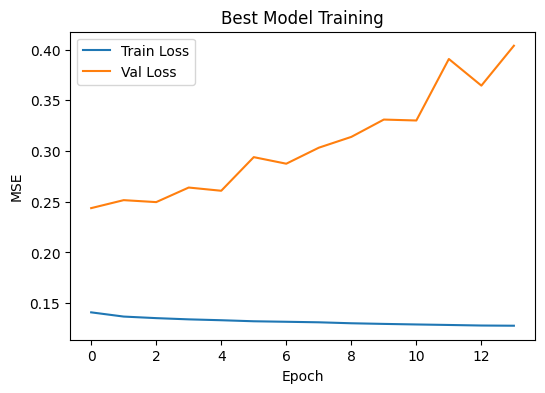

In [31]:
n_features = len(features)

def build_stacked_lstm(window_size, n_features, horizon,
                       units1, units2, dropout1, dropout2, lr):
    model = Sequential()
    # LSTM layer 1
    model.add(LSTM(units1,
                   return_sequences=True,
                   input_shape=(window_size, n_features)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout1))
    # LSTM layer 2
    model.add(LSTM(units2, return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(dropout2))
    # Dense output
    model.add(Dense(horizon, activation='linear'))
    # Compile
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='mse',
        metrics=['mae']
    )
    return model


def build_model_hp(hp):
    return build_stacked_lstm(
        window_size=window_size,
        n_features=n_features,
        horizon=horizon,
        units1=hp.Choice('units1', [64, 128, 256]),
        units2=hp.Choice('units2', [32, 64, 128]),
        dropout1=hp.Float('dropout1', 0.1, 0.5, step=0.1),
        dropout2=hp.Float('dropout2', 0.1, 0.5, step=0.1),
        lr=hp.Choice('lr', [1e-2, 1e-3, 1e-4])
    )


tuner = RandomSearch(
    build_model_hp,
    objective='val_loss',    
    max_trials=5,             
    executions_per_trial=1,
    directory='rs_lstm',
    project_name='lstm_rs'
)


tuner.search(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)

best_hp    = tuner.get_best_hyperparameters(num_trials=1)[0]
lstm_model = tuner.get_best_models(num_models=1)[0]

print("Best hyperparameters found:")
print(f"  units1   = {best_hp.get('units1')}")
print(f"  units2   = {best_hp.get('units2')}")
print(f"  dropout1 = {best_hp.get('dropout1'):.2f}")
print(f"  dropout2 = {best_hp.get('dropout2'):.2f}")
print(f"  lr       = {best_hp.get('lr')}")

history = lstm_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=13, restore_best_weights=True)
    ],
    verbose=1
)

plt.figure(figsize=(6,4))
plt.plot(history.history['loss'],  label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Best Model Training')
plt.legend()
plt.show()


In [32]:
X_test, y_test = make_sequences(dftest, features, target, window_size, horizon)
y_pred = lstm_model.predict(X_test)
model_eval(y_test, y_pred)

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Squared Error: 0.2966498612757993
Mean Absolute Error: 0.22869171711720745
R-squared: 0.33882332924567266
Pearson Correlation Coefficient: 0.586283761627753


# Weather forcast result

In [33]:
best_model = tensorflow.keras.models.load_model('best_lstm_model_final.h5', custom_objects={'mse': tensorflow.keras.losses.MeanSquaredError})

In [34]:
y_pred = best_model.predict(X_test)
model_eval(y_test, y_pred)

2314/2314 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Mean Squared Error: 0.2967674368184726
Mean Absolute Error: 0.24114549768335522
R-squared: 0.33845033923404716
Pearson Correlation Coefficient: 0.5887627802842692


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

C:\Users\giakh\AppData\Local\Temp\ipykernel_20864\1010191973.py:62: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


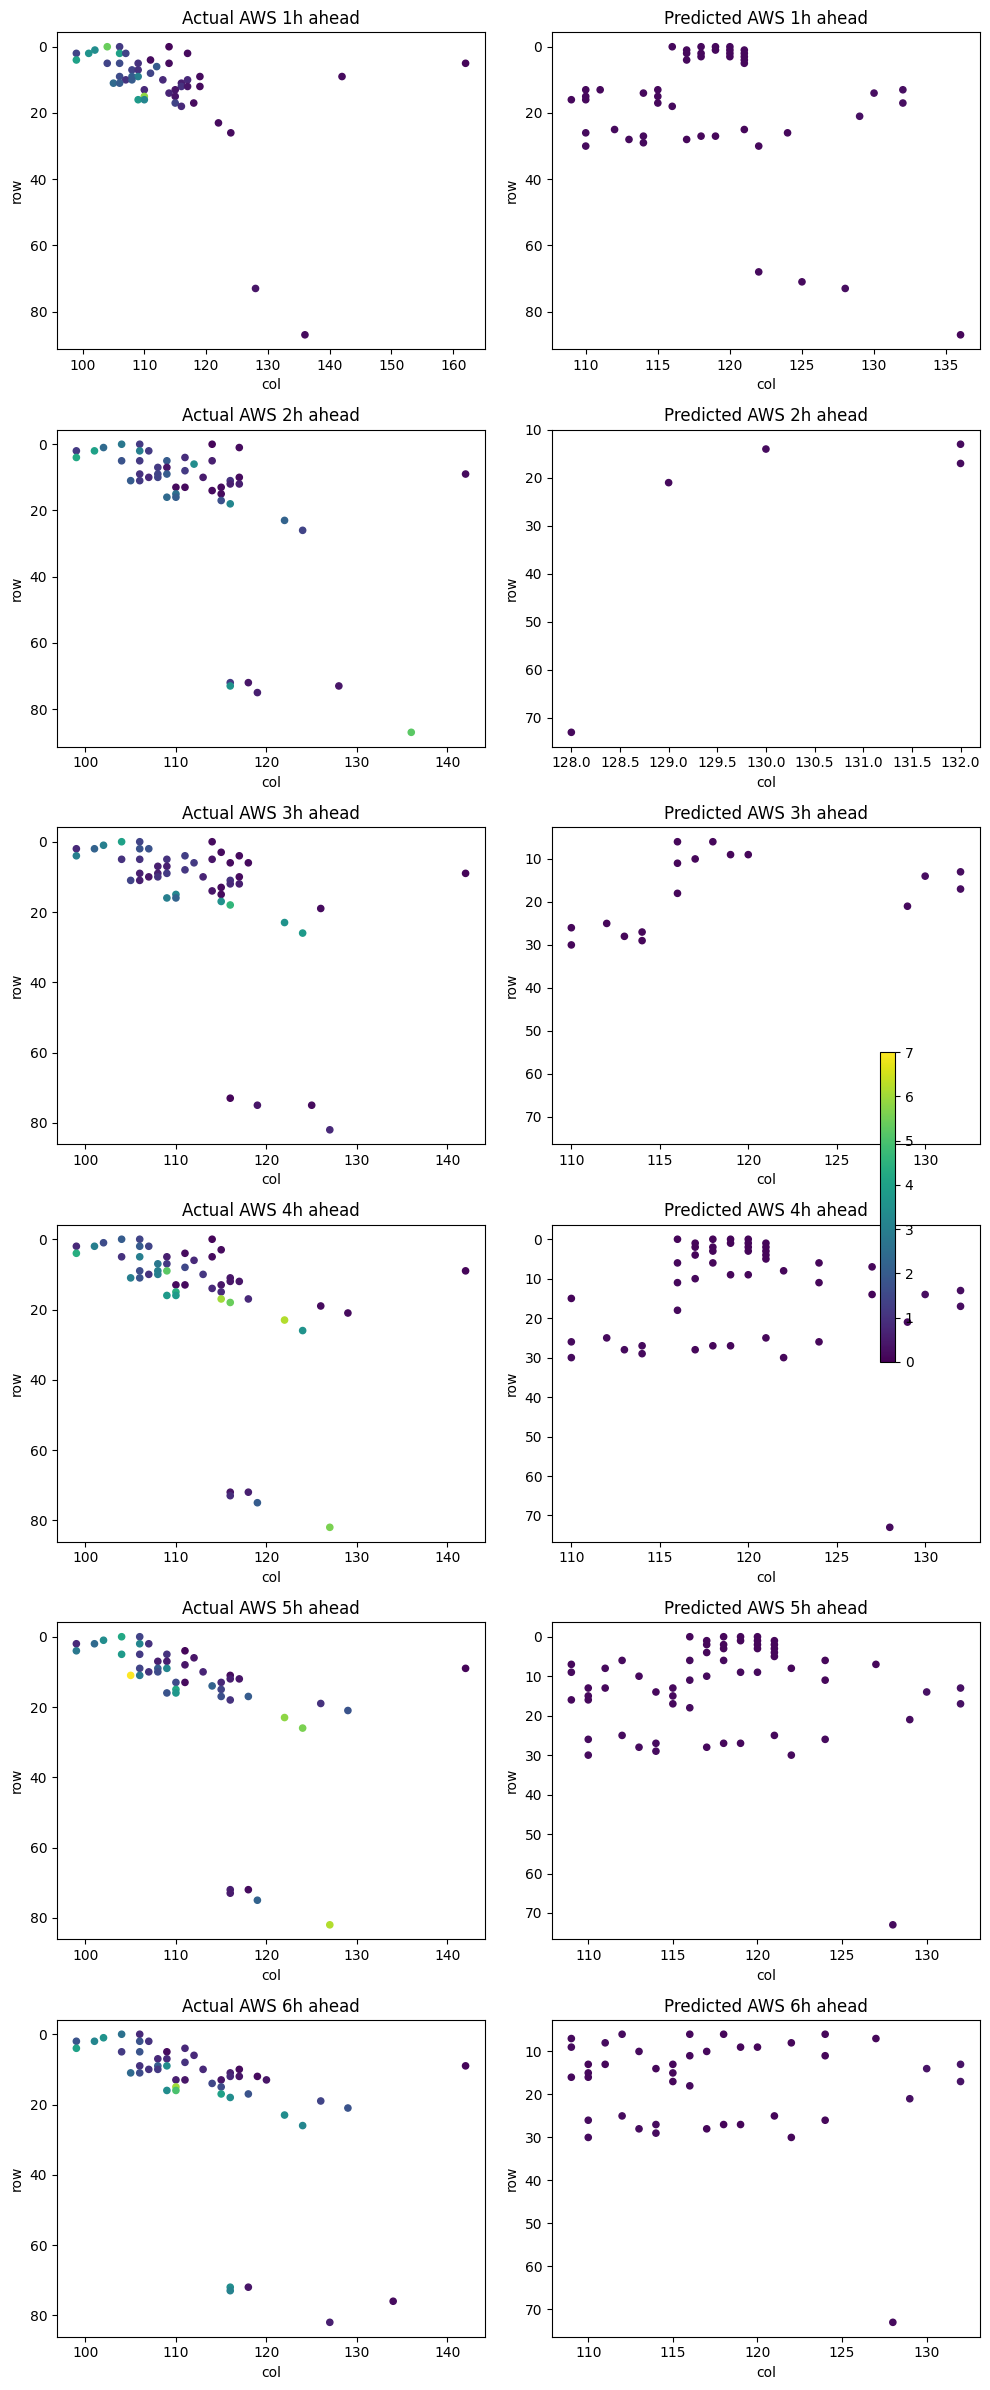

In [36]:
from datetime import timedelta


test_day   = pd.to_datetime('2020-10-29 09:00')
prev_times = [test_day - timedelta(hours=i) for i in range(window_size, 0, -1)]


coord_cols = ['row', 'col']
df2020     = df[df['datetime'].dt.year == 2020].copy()
grid       = df2020[coord_cols].drop_duplicates().reset_index(drop=True)
nP         = len(grid)
pred_map = np.full((horizon, nP), np.nan)
act_map  = np.full((horizon, nP), np.nan)

for idx, pt in grid.iterrows():
    cond   = (df2020['row']==pt['row']) & (df2020['col']==pt['col'])
    df_loc = df2020[cond].sort_values('datetime').reset_index(drop=True)
    df_win = df_loc[df_loc['datetime'].isin(prev_times)]
    if len(df_win) != window_size:
        continue
    
    Xd    = df_win[features].values.reshape(1, window_size, len(features))
    y_l   = best_model.predict(Xd).flatten()      
    pred_map[:, idx] = y_l
    
    df_act = df_loc[
        (df_loc['datetime'] >= test_day) &
        (df_loc['datetime'] <  test_day + timedelta(hours=horizon))
    ].sort_values('datetime')
    if len(df_act) != horizon:
        continue
    act_map[:, idx] = df_act[target].values

print(f"Built maps for {nP} points.")

vmin = np.nanmin(act_map)
vmax = np.nanmax(act_map)

pred_map[pred_map <= 0.1 ] = np.nan
act_map[act_map == 0 ] = np.nan

fig, axes = plt.subplots(nrows=horizon, ncols=2, figsize=(10, 4*horizon))
for h in range(horizon):
    ax1, ax2 = axes[h]
    sc1 = ax1.scatter(
        grid['col'], grid['row'], c=act_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax1.set_title(f'Actual AWS {h+1}h ahead')
    ax1.invert_yaxis()
    ax1.set_xlabel('col'); ax1.set_ylabel('row')

    sc2 = ax2.scatter(
        grid['col'], grid['row'], c=pred_map[h],
        s=20, vmin=vmin, vmax=vmax
    )
    ax2.set_title(f'Predicted AWS {h+1}h ahead')
    ax2.invert_yaxis()
    ax2.set_xlabel('col'); ax2.set_ylabel('row')

fig.colorbar(sc1, ax=axes, orientation='vertical', fraction=0.02)
plt.tight_layout()
plt.show()
